In [1]:
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from sklearn.metrics import accuracy_score
from tensorflow import keras
from sklearn import metrics
import tensorflow as tf
import pandas as pd
import numpy as np
import plotting
import hls4ml
import shap
import sys
import os

np.random.seed(77)

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)

/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/hls4ml_instruct_cnn/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [24]:
options = {
    'v'          : '10',
    'date'       : '2022_09_27',
    'inTagIdent' : '_lTauPtCut18',
    'inTagCalib' : '_lTauPtCut18_uEtacut1.5',
    'caloClNxM'  : '5x9'
}

In [25]:
indir = '/data_CMS/cms/motta/Phase2L1T/'+options['date']+'_v'+options['v']
identdir = indir+'/TauCNNIdentifier'+options['caloClNxM']+'Training'+options['inTagIdent']
calibdir = indir+'/TauCNNCalibrator'+options['caloClNxM']+'Training'+options['inTagCalib']

N = int(options['caloClNxM'].split('x')[0])
M = int(options['caloClNxM'].split('x')[1])

In [30]:
X1_id = np.load(identdir+'/X_CNN_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
X2_id = np.load(identdir+'/X_Dense_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
Y_id  = np.load(identdir+'/Y_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
# X1_id = np.sum(X1_id, axis=3, keepdims=True)


X1_id = np.float32(X1_id)
X2_id = np.float32(X2_id)
Y_id = np.float32(Y_id)

X1_id_reduced = X1_id[:3000]
X2_id_reduced = X2_id[:3000]
Y_id_reduced = Y_id[:3000]

In [27]:
# X1_cal = np.load(calibdir+'/X_CNN_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
# X2_cal = np.load(calibdir+'/X_Dense_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
# Y_cal  = np.load(calibdir+'/Y_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']

# X1_cal = np.float32(X1_cal)
# X2_cal = np.float32(X2_cal)
# Y_cal = np.float32(Y_cal)

# X1_cal_reduced = X1_cal[:3000]
# X2_cal_reduced = X2_cal[:3000]
# Y_cal_reduced = Y_cal[:3000]

In [28]:
CNN = keras.models.load_model(identdir+'/CNNmodel', compile=False)
# QCNN = keras.models.load_model(identdir+'/QCNNmodel', compile=False)

DNNident = keras.models.load_model(identdir+'/DNNmodel', compile=False)
# QDNNident = keras.models.load_model(identdir+'/QDNNmodel', compile=False)

# DNNcalib = keras.models.load_model(calibdir+'/TauCNNCalibrator', compile=False)
# QDNNcalib = keras.models.load_model(calibdir+'/TauCNNQCalibrator', compile=False)

In [29]:
print(CNN.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 TowerClusterImage (InputLayer)  [(None, 5, 9, 3)]   0           []                               
                                                                                                  
 CNNlayer1 (Conv2D)             (None, 4, 8, 4)      48          ['TowerClusterImage[0][0]']      
                                                                                                  
 BN_CNNlayer1 (BatchNormalizati  (None, 4, 8, 4)     16          ['CNNlayer1[0][0]']              
 on)                                                                                              
                                                                                                  
 RELU_CNNlayer1 (Activation)    (None, 4, 8, 4)      0           ['BN_CNNlayer1[0][0]']       

# NON-QUANTIZED MODELS FIRST

## Create HLS model for the identification CNN and DNN - NON-QUANTIZED

Interpreting Model
Topology:
Layer name: TowerClusterImage, layer type: Input
Layer name: CNNlayer1, layer type: Conv2D
  -> Activation (linear), layer name: CNNlayer1
Layer name: BN_CNNlayer1, layer type: BatchNormalization
Layer name: RELU_CNNlayer1, layer type: Activation
Layer name: MP_CNNlayer1, layer type: MaxPooling2D
Layer name: CNNlayer2, layer type: Conv2D
  -> Activation (linear), layer name: CNNlayer2
Layer name: BN_CNNlayer2, layer type: BatchNormalization
Layer name: RELU_CNNlayer2, layer type: Activation
Layer name: TowerClusterPosition, layer type: Input
Layer name: middleMan, layer type: Concatenate
{'Model': {'Precision': 'ap_fixed<19,7>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'TowerClusterImage': {'Precision': 'ap_fixed<16,9>', 'Strategy': 'Latency', 'ReuseFactor': 1, 'Trace': True}, 'CNNlayer1': {'Precision': 'ap_fixed<19,7>', 'ReuseFactor': 1, 'Strategy': 'Latency', 'Trace': True}, 'CNNlayer1_linear': {'Precision': 'ap_fixed<19,7>', 'ReuseFactor':

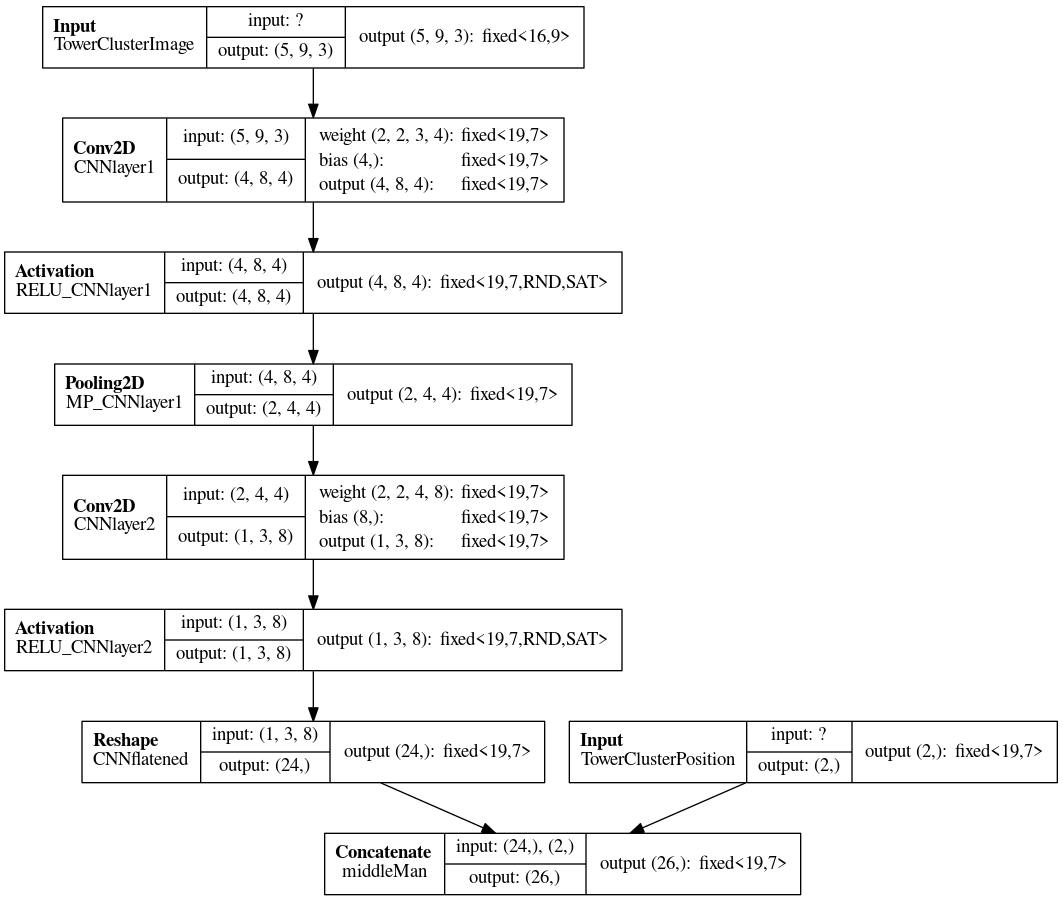

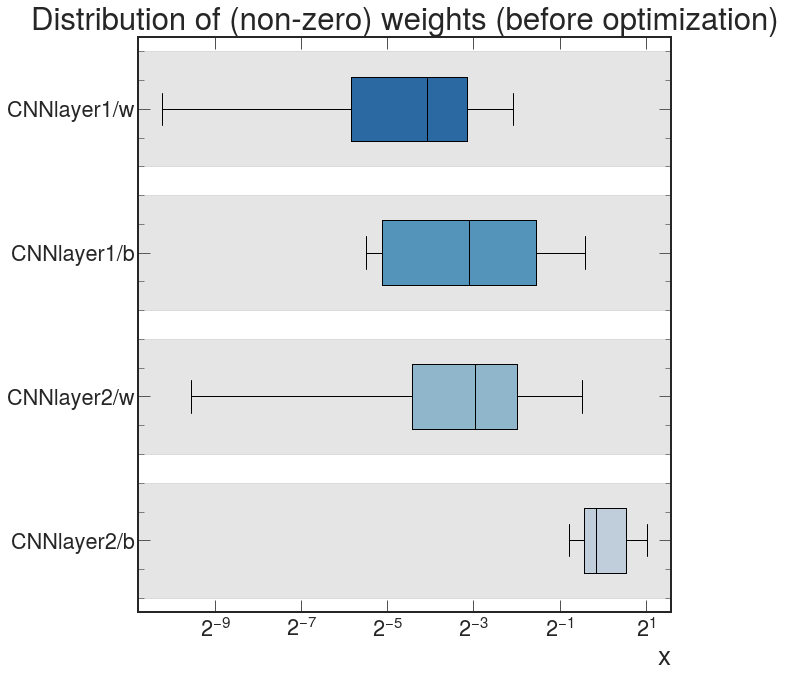

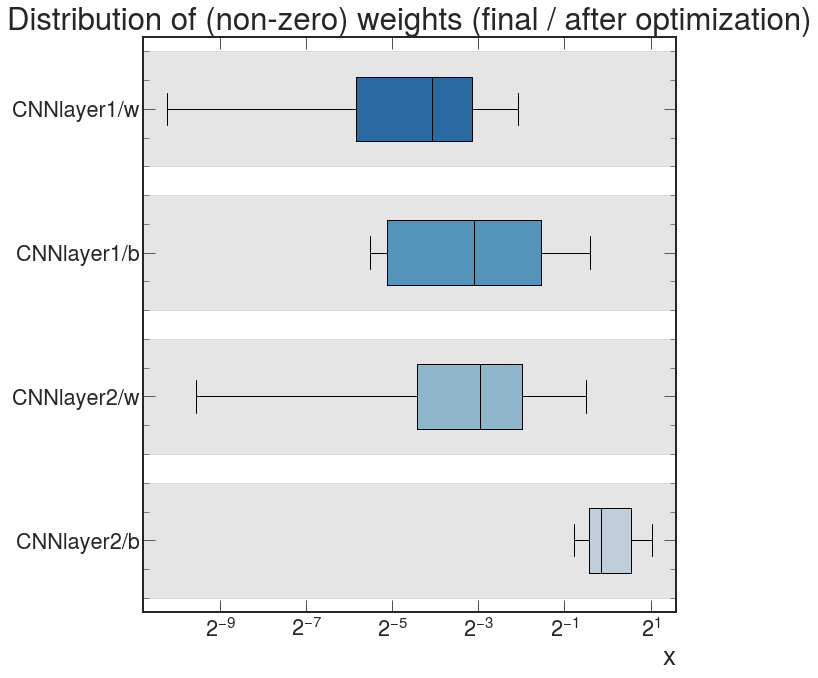

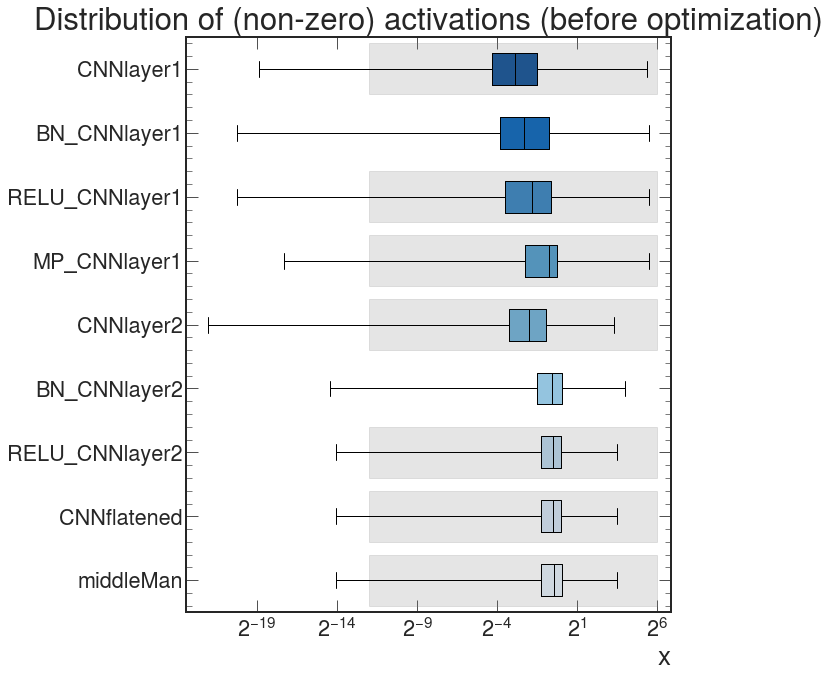

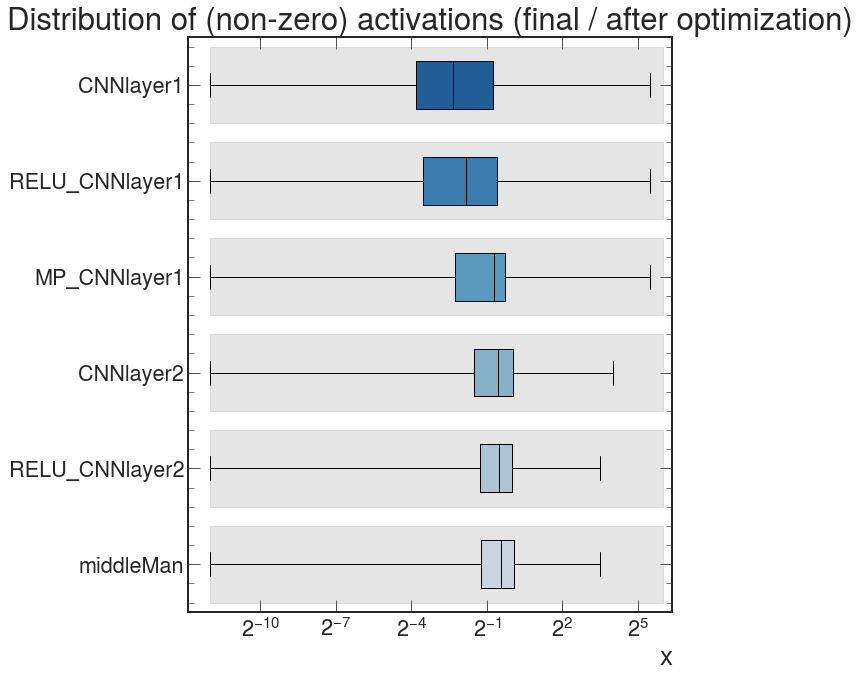

In [31]:
############################## Pass non-quantized CNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
CNN_hls_cfg = hls4ml.utils.config_from_keras_model(CNN, granularity='name')
CNN_hls_cfg['Model']['Precision'] = 'ap_fixed<19,7>'
CNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in CNN_hls_cfg['LayerName'].keys():
    CNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Latency'
    CNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    CNN_hls_cfg['LayerName'][Layer]['Trace'] = True
    CNN_hls_cfg['LayerName'][Layer]['Precision'] = 'ap_fixed<19,7>'
CNN_hls_cfg['LayerName']['TowerClusterImage']['Precision'] = 'ap_fixed<16,9>'
CNN_hls_cfg['LayerName']['middleMan']['Precision'] = 'ap_fixed<19,7>'
CNN_hls_cfg['LayerName']['middleMan']['Strategy'] = 'Stable'

print(CNN_hls_cfg)

CNN_cfg = hls4ml.converters.create_config(backend='Vivado')
CNN_cfg['IOType']     = 'io_parallel' # Must set this if using CNNs!
CNN_cfg['HLSConfig']  = CNN_hls_cfg
CNN_cfg['KerasModel'] = CNN
CNN_cfg['OutputDir']  = identdir+'/CNNmodel_HLS/'
CNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
CNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

CNN_hls = hls4ml.converters.keras_to_hls(CNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
CNN_hls.compile()

hls4ml.model.profiling.numerical(model=CNN, hls_model=CNN_hls, X=[X1_id_reduced,X2_id_reduced])
hls4ml.utils.plot_model(CNN_hls, show_shapes=True, show_precision=True, to_file=None)

Interpreting Model
Topology:
Layer name: CNNflattened, layer type: Input
Layer name: DNNlayer1, layer type: Dense
  -> Activation (linear), layer name: DNNlayer1
Layer name: RELU_DNNlayer1, layer type: Activation
Layer name: DNNlayer2, layer type: Dense
  -> Activation (linear), layer name: DNNlayer2
Layer name: RELU_DNNlayer2, layer type: Activation
Layer name: DNNout, layer type: Dense
  -> Activation (linear), layer name: DNNout
Layer name: sigmoid_DNNout, layer type: Activation
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'CNNflattened': {'Precision': {'result': 'ap_fixed<16,6>'}, 'Strategy': 'Latency', 'ReuseFactor': 1, 'Trace': True}, 'DNNlayer1': {'Precision': {'weight': 'ap_fixed<6,2>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<9,6>', 'accum': 'ap_fixed<14,5>'}, 'ReuseFactor': 1, 'Strategy': 'Latency', 'Trace': True}, 'DNNlayer1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_

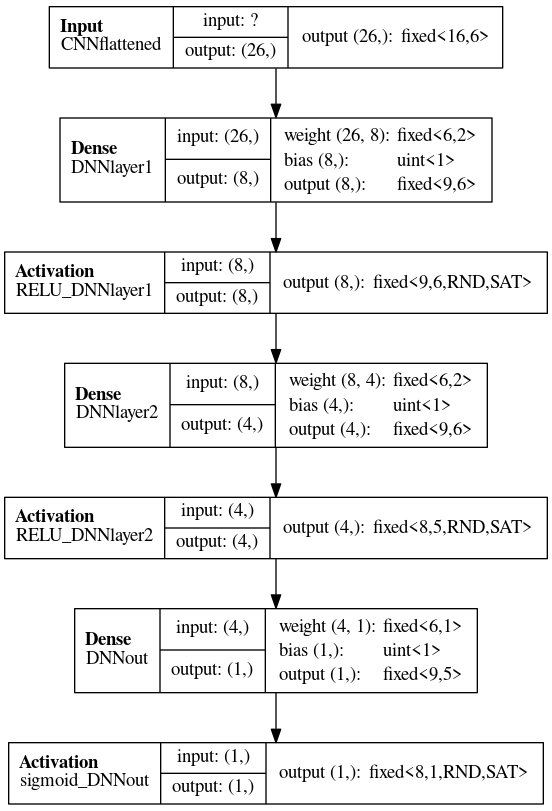

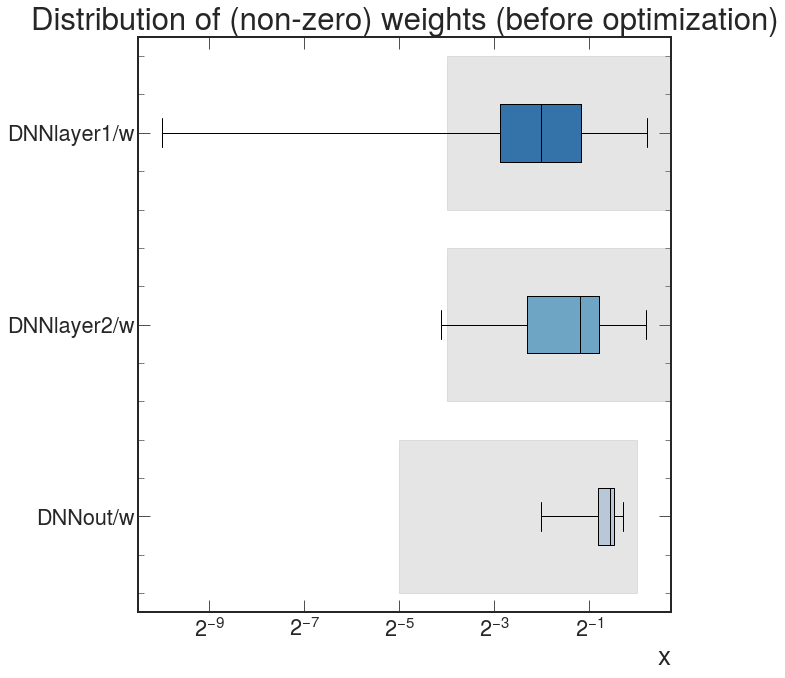

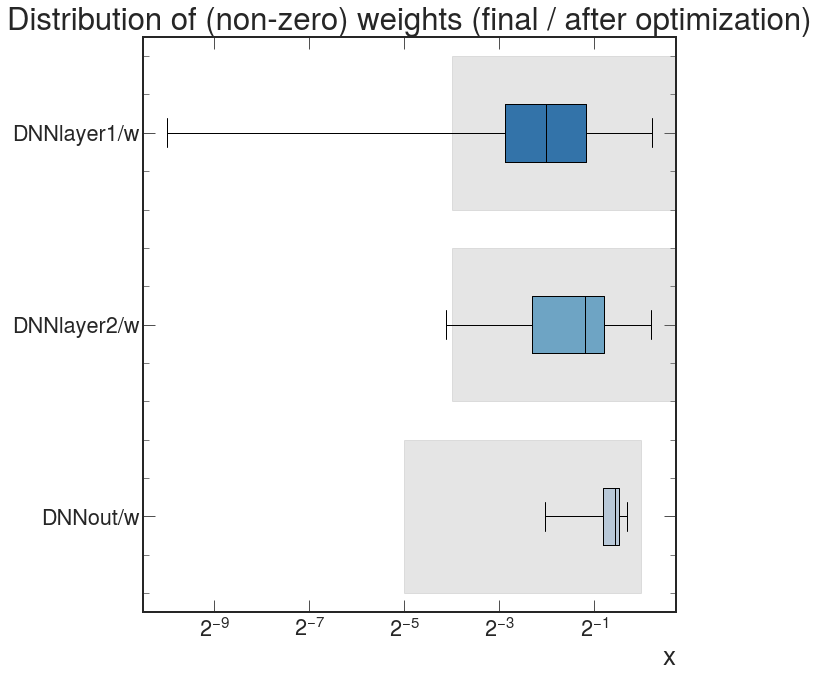

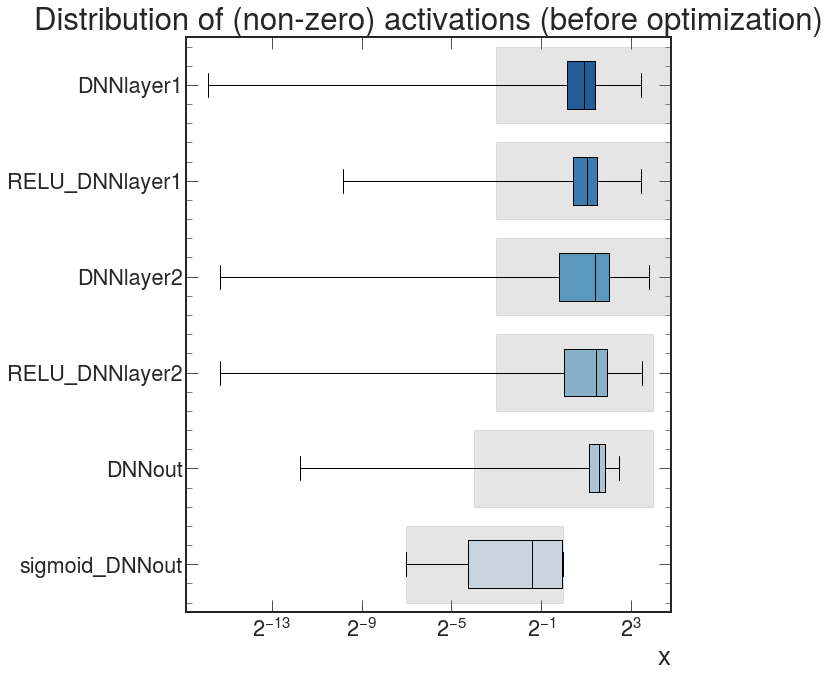

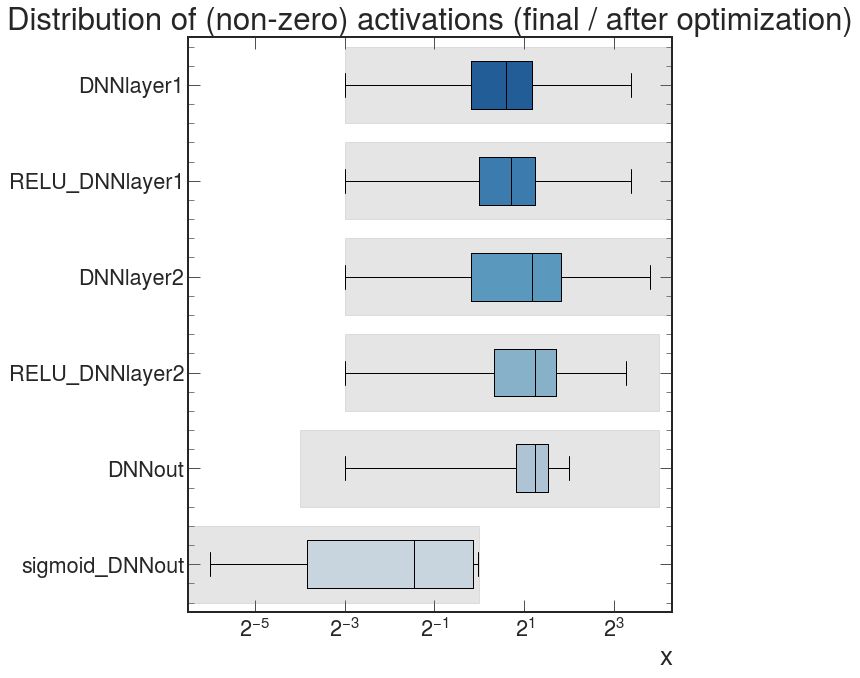

In [34]:
############################## Pass non-quantized identification DNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
id_DNN_hls_cfg = hls4ml.utils.config_from_keras_model(DNNident, granularity='name')
id_DNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
id_DNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in id_DNN_hls_cfg['LayerName'].keys():
    id_DNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Latency'
    id_DNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    id_DNN_hls_cfg['LayerName'][Layer]['Trace'] = True
id_DNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['weight'] = 'ap_fixed<6,2>'
id_DNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['result'] = 'ap_fixed<9,6>'
id_DNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['accum'] = 'ap_fixed<14,5>'
id_DNN_hls_cfg['LayerName']['RELU_DNNlayer1']['Precision'] = 'ap_fixed<9,6>'

id_DNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['weight'] = 'ap_fixed<6,2>'
id_DNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['result'] = 'ap_fixed<9,6>'
id_DNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['accum'] = 'ap_fixed<10,5>'
id_DNN_hls_cfg['LayerName']['RELU_DNNlayer2']['Precision'] = 'ap_fixed<8,5>'

id_DNN_hls_cfg['LayerName']['DNNout']['Precision']['weight'] = 'ap_fixed<6,1>'
id_DNN_hls_cfg['LayerName']['DNNout']['Precision']['result'] = 'ap_fixed<9,5>'
id_DNN_hls_cfg['LayerName']['DNNout']['Precision']['accum'] = 'ap_fixed<6,3>'

id_DNN_hls_cfg['LayerName']['sigmoid_DNNout']['Precision'] = 'ap_fixed<8,1>'
id_DNN_hls_cfg['LayerName']['sigmoid_DNNout']['Strategy'] = 'Stable'

print(id_DNN_hls_cfg)

id_DNN_cfg = hls4ml.converters.create_config(backend='Vivado')
id_DNN_cfg['IOType']     = 'io_parallel'
id_DNN_cfg['HLSConfig']  = id_DNN_hls_cfg
id_DNN_cfg['KerasModel'] = DNNident
id_DNN_cfg['OutputDir']  = identdir+'/DNNmodel_HLS/'
id_DNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
id_DNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

DNNident_hls = hls4ml.converters.keras_to_hls(id_DNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
DNNident_hls.compile()

id_CNNoutput = np.array(CNN([X1_id_reduced,X2_id_reduced]))

hls4ml.model.profiling.numerical(model=DNNident, hls_model=DNNident_hls, X=id_CNNoutput)
hls4ml.utils.plot_model(DNNident_hls, show_shapes=True, show_precision=True, to_file=None)

# COMPARE HLS TO KERAS AND QKERAS MODELS

In [35]:
def plotROC(Y, y_pred, y_pred_hls4ml, label="Model"):
    
    accuracy_keras  = float(accuracy_score(np.argmax(Y,axis=1), np.argmax(y_pred,axis=1), normalize=True))
    accuracy_hls4ml = float(accuracy_score(np.argmax(Y,axis=1), np.argmax(y_pred_hls4ml,axis=1), normalize=True))

    print("Accuracy Keras:  {}".format(accuracy_keras))
    print("Accuracy hls4ml: {}".format(accuracy_hls4ml))
    
    fig, ax = plt.subplots(figsize=(10, 10))

    FPR, TPR, THR = metrics.roc_curve(Y, y_pred)
    AUC = metrics.roc_auc_score(Y, y_pred)
    
    FPR_HLS, TPR_HLS, THR_HLS = metrics.roc_curve(Y, y_pred_hls4ml)
    AUC_HLS = metrics.roc_auc_score(Y, y_pred_hls4ml)
    
    plt.plot(TPR, FPR, label=label+' ROC, AUC = %.3f' % (AUC),   color='blue',lw=2)
    plt.plot(TPR_HLS, FPR_HLS, label='HLS ROC, AUC = %.3f' % (AUC_HLS), color='green',lw=2)
    
    plt.legend(loc = 'upper left', fontsize=16)
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Efficiency')
    mplhep.cms.label('Phase-2 Simulation', data=True, rlabel='14 TeV, 200 PU')
    plt.ylim(0.01,1.)
    plt.xlim(0.7,1.)

In [36]:
# non-quantized models ID
y_ident        = DNNident.predict(CNN.predict([X1_id, X2_id]))
y_ident_hls4ml = DNNident_hls.predict(CNN_hls.predict([X1_id, X2_id]))

Accuracy Keras:  1.0
Accuracy hls4ml: 1.0


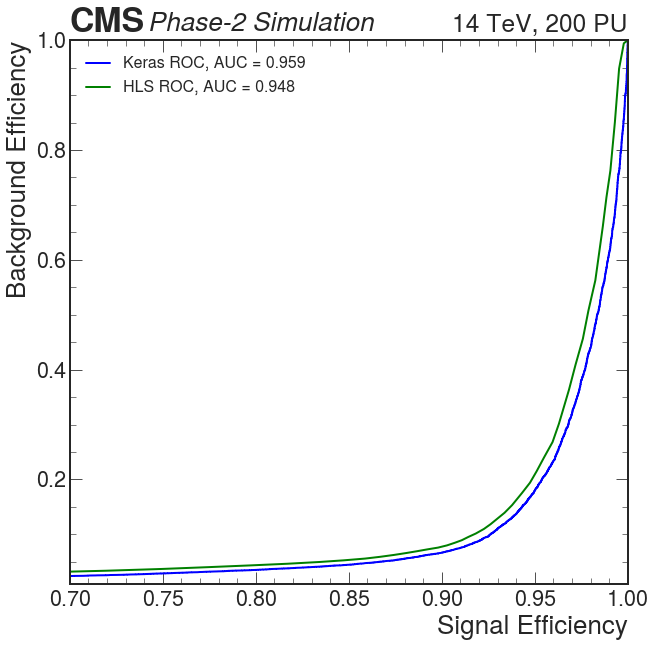

In [37]:
# Plot the floating point model:    
plotROC(Y_id,y_ident,y_ident_hls4ml,label="Keras") 

# SYNTHESISE MODELS WITH VIVADO

In [38]:
synth = True
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    CNN_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Tue Sep 27 16:54:05 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_27_v10/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_27_v10/TauC

INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:24 ; elapsed = 00:00:29 . Memory (MB): peak = 1067.066 ; gain = 544.977 ; free physical = 299262 ; free virtual = 374411
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::concatenate1d<ap_fixed<19, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<19, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<19, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config11>' (firmware/nnet_utils/nnet_merge.h:170:44).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<19, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<19, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, relu_config8>' (firmware/nnet_utils/nnet_activation.h:66:39).
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'PartitionLoop' (firmware/nnet_utils/nnet_conv2d_latency.h:196) in function 'nnet::conv_2d_cl<ap_fixed<19, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<19, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>' for pipelining.
I

INFO: [XFORM 203-101] Partitioning array 'pool.V' (firmware/nnet_utils/nnet_pooling.h:228) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'data_buf.i'  in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'data_buf.i'  in dimension 2 completely.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmat

INFO: [SCHED 204-61] Pipelining function 'fill_buffer'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 46.84 seconds; current allocated memory: 456.654 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.72 seconds; current allocated memory: 459.617 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_596' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining loop 'PartitionLoop'.
INFO: [SCHED 20

INFO: [RTGEN 206-100] Finished creating RTL model for 'fill_buffer'.
INFO: [HLS 200-111]  Elapsed time: 2.58 seconds; current allocated memory: 527.398 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_596' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Generating core module 'myproject_mux_1287_19_1_1': 128 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_mux_1287_1_1_1': 128 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_596'.
INFO: [HLS 200-111]  Elapsed time: 5.37 seconds; current allocated memory: 678.540 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_ap_fixed_ap_fixed_19_7_0_0_0_relu_config4_s' 
INFO: [HLS 2

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_13_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_14_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_15_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_16_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_17_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_18_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_19_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_20_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_21_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_22_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_100_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_101_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_102_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_103_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_104_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_105_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_106_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_107_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_108_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_109_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_58_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_59_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_60_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_61_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_62_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_63_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_64_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_65_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_66_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_67_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_20_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_21_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_22_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_23_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_24_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_25_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_26_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_27_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_28_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_29_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [Synth 8-256] done synthesizing module 'fill_buffer' (1#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_27_v10/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/fill_buffer.vhd:46]
	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 1 - type: integer 
	Parameter din1_WIDTH bound to: 1 - type: integer 
	Parameter din2_WIDTH bound to: 1 - type: integer 
	Parameter din3_WIDTH bound to: 1 - type: integer 
	Parameter din4_WIDTH bound to: 1 - type: integer 
	Parameter din5_WIDTH bound to: 1 - type: integer 
	Parameter din6_WIDTH bound to: 1 - type: integer 
	Parameter din7_WIDTH bound to: 1 - type: integer 
	Parameter din8_WIDTH bound to: 1 - type: integer 
	Parameter din9_WIDTH bound to: 1 - type: integer 
	Parameter din10_WIDTH bound to: 1 - type: integer 
	Parameter din11_WIDTH bound to: 1 - type: integer 
	Parameter din12_WIDTH bound to: 1 - type: integer 
	Param

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 1 - type: integer 
	Parameter din1_WIDTH bound to: 1 - type: integer 
	Parameter din2_WIDTH bound to: 1 - type: integer 
	Parameter din3_WIDTH bound to: 1 - type: integer 
	Parameter din4_WIDTH bound to: 1 - type: integer 
	Parameter din5_WIDTH bound to: 1 - type: integer 
	Parameter din6_WIDTH bound to: 1 - type: integer 
	Parameter din7_WIDTH bound to: 1 - type: integer 
	Parameter din8_WIDTH bound to: 1 - type: integer 
	Parameter din9_WIDTH bound to: 1 - type: integer 
	Parameter din10_WIDTH bound to: 1 - type: integer 
	Parameter din11_WIDTH bound to: 1 - type: integer 
	Parameter din12_WIDTH bound to: 1 - type: integer 
	Parameter din13_WIDTH bound to: 1 - type: integer 
	Parameter din14_WIDTH bound to: 1 - type: integer 
	Parameter din15_WIDTH bound to: 1 - type: integer 
	Parameter din16_WIDTH bound to: 1 - type: integer 
	Parameter din17_WIDTH bound to: 

	Parameter din13_WIDTH bound to: 1 - type: integer 
	Parameter din14_WIDTH bound to: 1 - type: integer 
	Parameter din15_WIDTH bound to: 1 - type: integer 
	Parameter din16_WIDTH bound to: 1 - type: integer 
	Parameter din17_WIDTH bound to: 1 - type: integer 
	Parameter din18_WIDTH bound to: 1 - type: integer 
	Parameter din19_WIDTH bound to: 1 - type: integer 
	Parameter din20_WIDTH bound to: 1 - type: integer 
	Parameter din21_WIDTH bound to: 1 - type: integer 
	Parameter din22_WIDTH bound to: 1 - type: integer 
	Parameter din23_WIDTH bound to: 1 - type: integer 
	Parameter din24_WIDTH bound to: 1 - type: integer 
	Parameter din25_WIDTH bound to: 1 - type: integer 
	Parameter din26_WIDTH bound to: 1 - type: integer 
	Parameter din27_WIDTH bound to: 1 - type: integer 
	Parameter din28_WIDTH bound to: 1 - type: integer 
	Parameter din29_WIDTH bound to: 1 - type: integer 
	Parameter din30_WIDTH bound to: 1 - type: integer 
	Parameter din31_WIDTH bound to: 1 - type: integer 
	Parameter d

	Parameter din78_WIDTH bound to: 1 - type: integer 
	Parameter din79_WIDTH bound to: 1 - type: integer 
	Parameter din80_WIDTH bound to: 1 - type: integer 
	Parameter din81_WIDTH bound to: 1 - type: integer 
	Parameter din82_WIDTH bound to: 1 - type: integer 
	Parameter din83_WIDTH bound to: 1 - type: integer 
	Parameter din84_WIDTH bound to: 1 - type: integer 
	Parameter din85_WIDTH bound to: 1 - type: integer 
	Parameter din86_WIDTH bound to: 1 - type: integer 
	Parameter din87_WIDTH bound to: 1 - type: integer 
	Parameter din88_WIDTH bound to: 1 - type: integer 
	Parameter din89_WIDTH bound to: 1 - type: integer 
	Parameter din90_WIDTH bound to: 1 - type: integer 
	Parameter din91_WIDTH bound to: 1 - type: integer 
	Parameter din92_WIDTH bound to: 1 - type: integer 
	Parameter din93_WIDTH bound to: 1 - type: integer 
	Parameter din94_WIDTH bound to: 1 - type: integer 
	Parameter din95_WIDTH bound to: 1 - type: integer 
	Parameter din96_WIDTH bound to: 1 - type: integer 
	Parameter d

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 1 - type: integer 
	Parameter din1_WIDTH bound to: 1 - type: integer 
	Parameter din2_WIDTH bound to: 1 - type: integer 
	Parameter din3_WIDTH bound to: 1 - type: integer 
	Parameter din4_WIDTH bound to: 1 - type: integer 
	Parameter din5_WIDTH bound to: 1 - type: integer 
	Parameter din6_WIDTH bound to: 1 - type: integer 
	Parameter din7_WIDTH bound to: 1 - type: integer 
	Parameter din8_WIDTH bound to: 1 - type: integer 
	Parameter din9_WIDTH bound to: 1 - type: integer 
	Parameter din10_WIDTH bound to: 1 - type: integer 
	Parameter din11_WIDTH bound to: 1 - type: integer 
	Parameter din12_WIDTH bound to: 1 - type: integer 
	Parameter din13_WIDTH bound to: 1 - type: integer 
	Parameter din14_WIDTH bound to: 1 - type: integer 
	Parameter din15_WIDTH bound to: 1 - type: integer 
	Parameter din16_WIDTH bound to: 1 - type: integer 
	Parameter din17_WIDTH bound to: 

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 19 - type: integer 
	Parameter din1_WIDTH bound to: 19 - type: integer 
	Parameter din2_WIDTH bound to: 19 - type: integer 
	Parameter din3_WIDTH bound to: 19 - type: integer 
	Parameter din4_WIDTH bound to: 19 - type: integer 
	Parameter din5_WIDTH bound to: 19 - type: integer 
	Parameter din6_WIDTH bound to: 19 - type: integer 
	Parameter din7_WIDTH bound to: 19 - type: integer 
	Parameter din8_WIDTH bound to: 19 - type: integer 
	Parameter din9_WIDTH bound to: 19 - type: integer 
	Parameter din10_WIDTH bound to: 19 - type: integer 
	Parameter din11_WIDTH bound to: 19 - type: integer 
	Parameter din12_WIDTH bound to: 19 - type: integer 
	Parameter din13_WIDTH bound to: 19 - type: integer 
	Parameter din14_WIDTH bound to: 19 - type: integer 
	Parameter din15_WIDTH bound to: 19 - type: integer 
	Parameter din16_WIDTH bound to: 19 - type: integer 
	Parameter din17

	Parameter din79_WIDTH bound to: 19 - type: integer 
	Parameter din80_WIDTH bound to: 19 - type: integer 
	Parameter din81_WIDTH bound to: 19 - type: integer 
	Parameter din82_WIDTH bound to: 19 - type: integer 
	Parameter din83_WIDTH bound to: 19 - type: integer 
	Parameter din84_WIDTH bound to: 19 - type: integer 
	Parameter din85_WIDTH bound to: 19 - type: integer 
	Parameter din86_WIDTH bound to: 19 - type: integer 
	Parameter din87_WIDTH bound to: 19 - type: integer 
	Parameter din88_WIDTH bound to: 19 - type: integer 
	Parameter din89_WIDTH bound to: 19 - type: integer 
	Parameter din90_WIDTH bound to: 19 - type: integer 
	Parameter din91_WIDTH bound to: 19 - type: integer 
	Parameter din92_WIDTH bound to: 19 - type: integer 
	Parameter din93_WIDTH bound to: 19 - type: integer 
	Parameter din94_WIDTH bound to: 19 - type: integer 
	Parameter din95_WIDTH bound to: 19 - type: integer 
	Parameter din96_WIDTH bound to: 19 - type: integer 
	Parameter din97_WIDTH bound to: 19 - type: in

	Parameter din81_WIDTH bound to: 19 - type: integer 
	Parameter din82_WIDTH bound to: 19 - type: integer 
	Parameter din83_WIDTH bound to: 19 - type: integer 
	Parameter din84_WIDTH bound to: 19 - type: integer 
	Parameter din85_WIDTH bound to: 19 - type: integer 
	Parameter din86_WIDTH bound to: 19 - type: integer 
	Parameter din87_WIDTH bound to: 19 - type: integer 
	Parameter din88_WIDTH bound to: 19 - type: integer 
	Parameter din89_WIDTH bound to: 19 - type: integer 
	Parameter din90_WIDTH bound to: 19 - type: integer 
	Parameter din91_WIDTH bound to: 19 - type: integer 
	Parameter din92_WIDTH bound to: 19 - type: integer 
	Parameter din93_WIDTH bound to: 19 - type: integer 
	Parameter din94_WIDTH bound to: 19 - type: integer 
	Parameter din95_WIDTH bound to: 19 - type: integer 
	Parameter din96_WIDTH bound to: 19 - type: integer 
	Parameter din97_WIDTH bound to: 19 - type: integer 
	Parameter din98_WIDTH bound to: 19 - type: integer 
	Parameter din99_WIDTH bound to: 19 - type: in

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 19 - type: integer 
	Parameter din1_WIDTH bound to: 19 - type: integer 
	Parameter din2_WIDTH bound to: 19 - type: integer 
	Parameter din3_WIDTH bound to: 19 - type: integer 
	Parameter din4_WIDTH bound to: 19 - type: integer 
	Parameter din5_WIDTH bound to: 19 - type: integer 
	Parameter din6_WIDTH bound to: 19 - type: integer 
	Parameter din7_WIDTH bound to: 19 - type: integer 
	Parameter din8_WIDTH bound to: 19 - type: integer 
	Parameter din9_WIDTH bound to: 19 - type: integer 
	Parameter din10_WIDTH bound to: 19 - type: integer 
	Parameter din11_WIDTH bound to: 19 - type: integer 
	Parameter din12_WIDTH bound to: 19 - type: integer 
	Parameter din13_WIDTH bound to: 19 - type: integer 
	Parameter din14_WIDTH bound to: 19 - type: integer 
	Parameter din15_WIDTH bound to: 19 - type: integer 
	Parameter din16_WIDTH bound to: 19 - type: integer 
	Parameter din17

	Parameter din62_WIDTH bound to: 19 - type: integer 
	Parameter din63_WIDTH bound to: 19 - type: integer 
	Parameter din64_WIDTH bound to: 19 - type: integer 
	Parameter din65_WIDTH bound to: 19 - type: integer 
	Parameter din66_WIDTH bound to: 19 - type: integer 
	Parameter din67_WIDTH bound to: 19 - type: integer 
	Parameter din68_WIDTH bound to: 19 - type: integer 
	Parameter din69_WIDTH bound to: 19 - type: integer 
	Parameter din70_WIDTH bound to: 19 - type: integer 
	Parameter din71_WIDTH bound to: 19 - type: integer 
	Parameter din72_WIDTH bound to: 19 - type: integer 
	Parameter din73_WIDTH bound to: 19 - type: integer 
	Parameter din74_WIDTH bound to: 19 - type: integer 
	Parameter din75_WIDTH bound to: 19 - type: integer 
	Parameter din76_WIDTH bound to: 19 - type: integer 
	Parameter din77_WIDTH bound to: 19 - type: integer 
	Parameter din78_WIDTH bound to: 19 - type: integer 
	Parameter din79_WIDTH bound to: 19 - type: integer 
	Parameter din80_WIDTH bound to: 19 - type: in

INFO: [Synth 8-256] done synthesizing module 'conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_596' (4#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_27_v10/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_596.vhd:159]
INFO: [Synth 8-638] synthesizing module 'relu_ap_fixed_ap_fixed_19_7_0_0_0_relu_config4_s' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_27_v10/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_19_7_0_0_0_relu_config4_s.vhd:280]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_27_v10/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_19_7_0_0_0_relu_config4_s.vhd:290]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/data__data.polcms/cms/motta/Ph

	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 19 - type: integer 
	Parameter din1_WIDTH bound to: 19 - type: integer 
	Parameter din2_WIDTH bound to: 19 - type: integer 
	Parameter din3_WIDTH bound to: 19 - type: integer 
	Parameter din4_WIDTH bound to: 19 - type: integer 
	Parameter din5_WIDTH bound to: 19 - type: integer 
	Parameter din6_WIDTH bound to: 19 - type: integer 
	Parameter din7_WIDTH bound to: 19 - type: integer 
	Parameter din8_WIDTH bound to: 19 - type: integer 
	Parameter din9_WIDTH bound to: 19 - type: integer 
	Parameter din10_WIDTH bound to: 19 - type: integer 
	Parameter din11_WIDTH bound to: 19 - type: integer 
	Parameter din12_WIDTH bound to: 19 - type: integer 
	Parameter din13_WIDTH bound to: 19 - type: integer 
	Parameter din14_WIDTH bound to: 19 - type: integer 
	Parameter din15_WIDTH bound to: 19 - type: integer 
	Parameter din16_WIDTH bound to: 19 - type: integer 
	Parameter din17_WIDTH bound to: 19 - type: integer 
	Param

INFO: [Synth 8-256] done synthesizing module 'conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config6_s' (11#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_27_v10/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config6_s.vhd:80]
INFO: [Synth 8-638] synthesizing module 'relu_ap_fixed_ap_fixed_19_7_0_0_0_relu_config8_s' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_27_v10/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_19_7_0_0_0_relu_config8_s.vhd:72]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_27_v10/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_19_7_0_0_0_relu_config8_s.vhd:82]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1

INFO: [Synth 8-4490] FSM extraction disabled for register 'ap_CS_fsm_reg' through user attribute
INFO: [Synth 8-4490] FSM extraction disabled for register 'ap_CS_fsm_reg' through user attribute
INFO: [Synth 8-4490] FSM extraction disabled for register 'ap_CS_fsm_reg' through user attribute
INFO: [Synth 8-5818] HDL ADVISOR - The operator resource <adder> is shared. To prevent sharing consider applying a KEEP on the output of the operator [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_27_v10/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/fifo_w38_d6_A.vhd:102]
---------------------------------------------------------------------------------
Finished RTL Optimization Phase 2 : Time (s): cpu = 00:00:29 ; elapsed = 00:00:31 . Memory (MB): peak = 2124.199 ; gain = 501.305 ; free physical = 297923 ; free virtual = 372897
---------------------------------------------------------------------------------

Report RTL Partitions: 
+------+----------

+---Muxes : 
	   2 Input      1 Bit        Muxes := 3     
Module fifo_w18_d2_A_shiftReg__103 
Detailed RTL Component Info : 
+---Registers : 
	               18 Bit    Registers := 2     
+---Muxes : 
	   2 Input     18 Bit        Muxes := 1     
Module fifo_w18_d2_A__103 
Detailed RTL Component Info : 
+---Adders : 
	   2 Input      2 Bit       Adders := 1     
+---Registers : 
	                2 Bit    Registers := 1     
	                1 Bit    Registers := 2     
+---Muxes : 
	   2 Input      1 Bit        Muxes := 3     
Module fifo_w18_d2_A_shiftReg__104 
Detailed RTL Component Info : 
+---Registers : 
	               18 Bit    Registers := 2     
+---Muxes : 
	   2 Input     18 Bit        Muxes := 1     
Module fifo_w18_d2_A__104 
Detailed RTL Component Info : 
+---Adders : 
	   2 Input      2 Bit       Adders := 1     
+---Registers : 
	                2 Bit    Registers := 1     
	                1 Bit    Registers := 2     
+---Muxes : 
	   2 Input      1 Bit        Muxes :

Part Resources:
DSPs: 12288 (col length:96)
BRAMs: 5376 (col length: RAMB18 384 RAMB36 192)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
INFO: [Synth 8-5580] Multithreading enabled for synth_design using a maximum of 4 processes.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP mul_ln1118_122_fu_3304_p2, operation Mode is: A*(B:0x3fdf4).
DSP Report: operator mul_ln1118_122_fu_3304_p2 is absorbed into DSP mul_ln1118_122_fu_3304_p2.
DSP Report: Generating DSP mul_ln1118_118_fu_3276_p2, operation Mode is: A*(B:0x3fcf4).
DSP Report: operator mul_ln1118_118_fu_3276_p2 is absorbed into DSP mul_ln1118_118_fu_3276_p2.
DSP Report: Generating DSP mul_ln1118_129_fu_32


Report RTL Partitions: 
+------+----------------------------------------------------------+------------+----------+
|      |RTL Partition                                             |Replication |Instances |
+------+----------------------------------------------------------+------------+----------+
|1     |conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_596__GB0  |           1|     18406|
|2     |conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_596__GB1  |           1|       320|
|3     |conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_596__GB2  |           1|       131|
|4     |conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_596__GB3  |           1|       255|
|5     |conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_596__GB4  |           1|       348|
|6     |conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_596__GB5  |           1|       346|
|7     |conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_596__GB6  |           1|       553|
|8     |conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2

---------------------------------------------------------------------------------
Finished Timing Optimization : Time (s): cpu = 00:01:27 ; elapsed = 00:02:38 . Memory (MB): peak = 3385.676 ; gain = 1762.781 ; free physical = 290484 ; free virtual = 365760
---------------------------------------------------------------------------------

Report RTL Partitions: 
+------+----------------------------------------------------------+------------+----------+
|      |RTL Partition                                             |Replication |Instances |
+------+----------------------------------------------------------+------------+----------+
|1     |conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_596__GB0  |           1|     18406|
|2     |conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_596__GB1  |           1|       315|
|3     |conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_596__GB2  |           1|       128|
|4     |conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_596__GB3  |           1|    

---------------------------------------------------------------------------------
Start Handling Custom Attributes
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Handling Custom Attributes : Time (s): cpu = 00:01:43 ; elapsed = 00:02:56 . Memory (MB): peak = 3393.680 ; gain = 1770.785 ; free physical = 290449 ; free virtual = 365766
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Renaming Generated Nets
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Renaming Generated Nets : Time (s): cpu = 00:01:43 ; elapsed = 00:02:56 . Memory (MB): peak = 3393.680 ; gain = 1770.785 ; free physical = 290449 ; free virtual = 365766
--

Synthesis Optimization Runtime : Time (s): cpu = 00:01:46 ; elapsed = 00:02:59 . Memory (MB): peak = 3393.680 ; gain = 1770.785 ; free physical = 296776 ; free virtual = 372094
Synthesis Optimization Complete : Time (s): cpu = 00:01:46 ; elapsed = 00:02:59 . Memory (MB): peak = 3393.680 ; gain = 1770.785 ; free physical = 296784 ; free virtual = 372093
INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:00.49 ; elapsed = 00:00:00.49 . Memory (MB): peak = 3393.680 ; gain = 0.000 ; free physical = 296749 ; free virtual = 372058
INFO: [Netlist 29-17] Analyzing 3235 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 1 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00.01 ; elapsed = 00:00:00 . Memory (MB): peak = 3475.441 ; gain = 0.000 ; free physical = 296614 ; free virt

In [39]:
synth = True
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    DNNident_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Tue Sep 27 17:00:28 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_27_v10/TauCNNIdentifier5x9Training_lTauPtCut18/DNNmodel_HLS'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_27_v10/TauC

INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:22 ; elapsed = 00:00:26 . Memory (MB): peak = 1131.363 ; gain = 609.273 ; free physical = 299455 ; free virtual = 374409
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<8, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>' (firmware/nnet_utils/nnet_dense_latency.h:34:50).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<8, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, relu_config5>' (firmware/nnet_utils/nnet_activation.h:66:26).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' (firmware/nnet_utils/nnet_dense_latency.h:39:55).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::r

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:48:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0' by setting 'biases[5].V' to 'b2.V.5'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:48:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0' by setting 'biases[6].V' to 'b2.V.6'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0'(firmw

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_ap_fixed_ap_fixed_8_5_0_0_0_relu_config5_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<ap_fixed,ap_fixed<8,5,0,0,0>,relu_config5>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.15 seconds; current allocated memory: 350.199 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.03 seconds; current allocated memory: 350.411 MB.
INFO: [HLS 200-10] -------------------

# synth_design -top myproject -part xcvu13p-fhgb2104-2L-e
Command: synth_design -top myproject -part xcvu13p-fhgb2104-2L-e
Starting synth_design
Attempting to get a license for feature 'Synthesis' and/or device 'xcvu13p'
INFO: [Common 17-349] Got license for feature 'Synthesis' and/or device 'xcvu13p'
INFO: Launching helper process for spawning children vivado processes
INFO: Helper process launched with PID 10556 
---------------------------------------------------------------------------------
Starting Synthesize : Time (s): cpu = 00:00:03 ; elapsed = 00:00:05 . Memory (MB): peak = 1839.426 ; gain = 216.613 ; free physical = 298704 ; free virtual = 373660
---------------------------------------------------------------------------------
INFO: [Synth 8-638] synthesizing module 'myproject' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_27_v10/TauCNNIdentifier5x9Training_lTauPtCut18/DNNmodel_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:27]
INFO: [Synth 8-5534] Detected at

---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:04 ; elapsed = 00:00:07 . Memory (MB): peak = 1904.188 ; gain = 281.375 ; free physical = 298732 ; free virtual = 373688
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:04 ; elapsed = 00:00:07 . Memory (MB): peak = 1910.117 ; gain = 287.305 ; free physical = 298731 ; free virtual = 373687
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Loading Part and Timing Information
---------------------------------------------------------------------------------
Loading part: xcvu13p-fhgb2104-2L-e
INFO: [Synth 8-6742] Reading net delay rules and data
-----------------------------------

INFO: [Synth 8-3886] merging instance 'layer3_out_2_V_reg_263_reg[7]' (FDE) to 'layer3_out_0_V_reg_253_reg[7]'
INFO: [Synth 8-3886] merging instance 'layer3_out_0_V_reg_253_reg[7]' (FDE) to 'layer3_out_1_V_reg_258_reg[7]'
INFO: [Synth 8-3886] merging instance 'layer3_out_3_V_reg_268_reg[7]' (FDE) to 'layer3_out_1_V_reg_258_reg[7]'
INFO: [Synth 8-3886] merging instance 'layer3_out_5_V_reg_278_reg[7]' (FDE) to 'layer3_out_1_V_reg_258_reg[7]'
INFO: [Synth 8-3886] merging instance 'layer3_out_6_V_reg_283_reg[7]' (FDE) to 'layer3_out_1_V_reg_258_reg[7]'
INFO: [Synth 8-3886] merging instance 'layer3_out_7_V_reg_288_reg[7]' (FDE) to 'layer3_out_1_V_reg_258_reg[7]'
INFO: [Synth 8-3886] merging instance 'layer3_out_1_V_reg_258_reg[7]' (FDE) to 'layer3_out_4_V_reg_273_reg[7]'
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer3_out_4_V_reg_273_reg[7] )
---------------------------------------------------------------------------------
Finished Cross Boundary and Area Opti

---------------------------------------------------------------------------------
Start Handling Custom Attributes
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Handling Custom Attributes : Time (s): cpu = 00:00:31 ; elapsed = 00:00:53 . Memory (MB): peak = 2914.703 ; gain = 1291.891 ; free physical = 297704 ; free virtual = 372666
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Renaming Generated Nets
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Renaming Generated Nets : Time (s): cpu = 00:00:31 ; elapsed = 00:00:53 . Memory (MB): peak = 2914.703 ; gain = 1291.891 ; free physical = 297704 ; free virtual = 372666
--